This project contains the data analysis of the Brazilian E-Commerce Public Dataset by Olist on Kaggle. You can access the dataset via this link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_products_dataset.csv

# Libraries

"folium paketi", Python'da interaktif haritalar oluşturmak için kullanılan bir kütüphanedir. Leaflet.js adlı JavaScript kütüphanesini Python ile birleştirerek coğrafi verileri görselleştirmenizi sağlar.

In [4]:
pip install folium --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install folium --upgrade --user

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

#Reading the Data

The Olist dataset has 9 different data files. Let's read these files and import them as dataframes.

In [10]:
# Imports all datatables as dataframe
customer = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
name = pd.read_csv('product_category_name_translation.csv')

In [11]:
# Collections for each dataset
datasets = [customer, geolocation, orders, order_items, order_payments, order_reviews, products, sellers, name]
names = ['customer', 'geolocation', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'name'] 

In [12]:
# Creates a dataframe that returns columns from all datasets
data_columns = pd.DataFrame({})
data_columns['dataset_name'] = names
data_columns['feature'] = [df.columns for df in datasets]
data_columns.style.background_gradient()

,dataset_name,feature
0,customer,"Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'], dtype='object')"
1,geolocation,"Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'], dtype='object')"
2,orders,"Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], dtype='object')"
3,order_items,"Index(['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'], dtype='object')"
4,order_payments,"Index(['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value'], dtype='object')"
5,order_reviews,"Index(['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'], dtype='object')"
6,products,"Index(['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'], dtype='object')"
7,sellers,"Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')"
8,name,"Index(['product_category_name', 'product_category_name_english'], dtype='object')"


In [13]:
# Creates a dataframe containing information about rows and columns
data_info = pd.DataFrame({})
data_info['dataset_name'] = names
data_info['rows'] = [df.shape[0] for df in datasets]
data_info['cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient(cmap='PuBuGn')

,dataset_name,rows,cols,null_amount,qty_null_columns,null_columns
0,customer,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,order_items,112650,7,0,0,
4,order_payments,103886,5,0,0,
5,order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,3095,4,0,0,
8,name,71,2,0,0,


#Data Preprocessing

**Data Integration**

The product category names are in Portuguese as the data is from the Brazilian e-commerce site Olist. We take the English equivalents from the *name* table and combine them.

In [17]:
name

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [18]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [45]:
products = products.merge(name, how='left', on='product_category_name') # name and products table are combined on product_category_name
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art


**Data Reduction**

In [47]:
# Unused columns are dropped from the products table
products = products.drop(columns=['product_category_name', 'product_name_lenght','product_description_lenght','product_photos_qty'])
products.head(2)

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,1000.0,30.0,18.0,20.0,art


In [48]:
# Unused columns are dropped from the order_reviews table
order_reviews = order_reviews.drop(columns=['review_creation_date', 'review_answer_timestamp'])
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN


**Data Cleaning**

Missing values are checked after integration and reduction in the *products* table. Rows with missing values are removed.

In [51]:
products.isnull().sum()

product_id                         0
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

In [52]:
products = products.dropna()

In [53]:
products.isnull().sum()

product_id                       0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

We are not dropping the missing values in the *order_reviews* table as we will use them as part of the analysis.

In [55]:
order_reviews.isnull().sum()

review_id                     0
order_id                      0
review_score                  0
review_comment_title      87656
review_comment_message    58247
dtype: int64

When we check the missing values in the *orders* table, we see that there are null values in the columns below. 

*   order_approved_at : Shows the payment approval timestamp.
*   order_delivered_carrier_date : Shows the order posting timestamp. When it was handled to the logistic partner.
*   order_delivered_customer_date : Shows the actual order delivery date to the customer

Considering what these dates correspond to, it makes sense that they are empty due to the status of the orders. However, an order with an order status as delivered must have a delivery date to the customer. We will clear some lines below with checks like this.

In [57]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [58]:
np.unique(orders.order_status)

array(['approved', 'canceled', 'created', 'delivered', 'invoiced',
       'processing', 'shipped', 'unavailable'], dtype=object)

In [59]:
np.unique(orders.order_status)

array(['approved', 'canceled', 'created', 'delivered', 'invoiced',
       'processing', 'shipped', 'unavailable'], dtype=object)

In [60]:
orders[orders.order_status == 'delivered'].isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [61]:
orders = orders[~((orders.order_status == 'delivered') & pd.isnull(orders.order_approved_at))]
orders = orders[~((orders.order_status == 'delivered') & pd.isnull(orders.order_delivered_carrier_date))]
orders = orders[~((orders.order_status == 'delivered') & pd.isnull(orders.order_delivered_customer_date))]

In [62]:
orders[orders.order_status == 'delivered'].isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [63]:
orders[orders.order_status == 'approved'].isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    2
order_estimated_delivery_date    0
dtype: int64

In [64]:
orders[orders.order_status == 'canceled'].isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     550
order_delivered_customer_date    619
order_estimated_delivery_date      0
dtype: int64

In [65]:
orders[orders.order_status == 'created'].isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                5
order_delivered_carrier_date     5
order_delivered_customer_date    5
order_estimated_delivery_date    0
dtype: int64

In [66]:
orders[orders.order_status == 'invoiced'].isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

In [67]:
orders[orders.order_status == 'processing'].isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

In [68]:
orders[orders.order_status == 'shipped'].isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

In [69]:
orders[orders.order_status == 'unavailable'].isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

In [70]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1781
order_delivered_customer_date    2957
order_estimated_delivery_date       0
dtype: int64

All missing values that are not compatible with the order status are cleared.

**Data Transformation**

In [73]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [74]:
# Changing the data type for date columns
orders_date = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for items in orders_date:
    orders[items] = pd.to_datetime(orders[items])

**Feature Extraction**

In [76]:
# Some temporal calculations in the orders table that may be required
orders['delayed'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date'])
orders['delay_time'] = orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
orders['total_time'] = orders['order_delivered_customer_date'] - orders['order_approved_at']
orders['prepare_time'] = orders['order_delivered_carrier_date'] - orders['order_approved_at']
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delayed,delay_time,total_time,prepare_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,-8 days +21:25:13,8 days 10:17:58,2 days 08:47:45
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,-6 days +15:27:45,12 days 12:03:18,0 days 11:06:33


# Data Analysis 

### Time Series

In [79]:
# Extracting attributes for purchase date - Year and Month
orders['order_purchase_year'] = orders['order_purchase_timestamp'].apply(lambda x: x.year)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.month)
orders['order_purchase_month_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders['order_purchase_year_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders['order_purchase_date'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
orders['order_purchase_day'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
orders['order_purchase_time_day'] = pd.cut(orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# Extracting attributes for purchase date - Season
order_season_agg = {'Spring' : ['Oct', 'Nov', 'Dec'],
                    'Summer' : ['Jan', 'Feb', 'Mar'],
                    'Autumn' : ['Apr', 'May', 'Jun'],
                    'Winter' : ['Jul', 'Aug', 'Sep']}
def season_agg(s):
    for item in order_season_agg:
        if s in order_season_agg[item]:
            return item
orders['order_purchase_season'] = orders['order_purchase_month_name'].apply(season_agg)

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delayed,delay_time,...,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_purchase_season
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,-8 days +21:25:13,...,10,Oct,201710,20171002,2,0,Mon,10,Morning,Spring
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,-6 days +15:27:45,...,7,Jul,201807,20180724,24,1,Tue,20,Night,Winter
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,False,-18 days +18:06:29,...,8,Aug,201808,20180808,8,2,Wed,8,Morning,Winter
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,False,-13 days +00:28:42,...,11,Nov,201711,20171118,18,5,Sat,19,Night,Spring
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,False,-10 days +18:17:02,...,2,Feb,201802,20180213,13,1,Tue,21,Night,Summer


C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\1139499520.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="order_purchase_year_month", y="order_id", data=orders.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(), ax=ax1, alpha=0.1, palette='YlGnBu')
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\1139499520.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="order_purchase_dayofweek_name", data=orders, order=day_order, ax=ax2, palette="YlGnBu")
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\1139499520.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

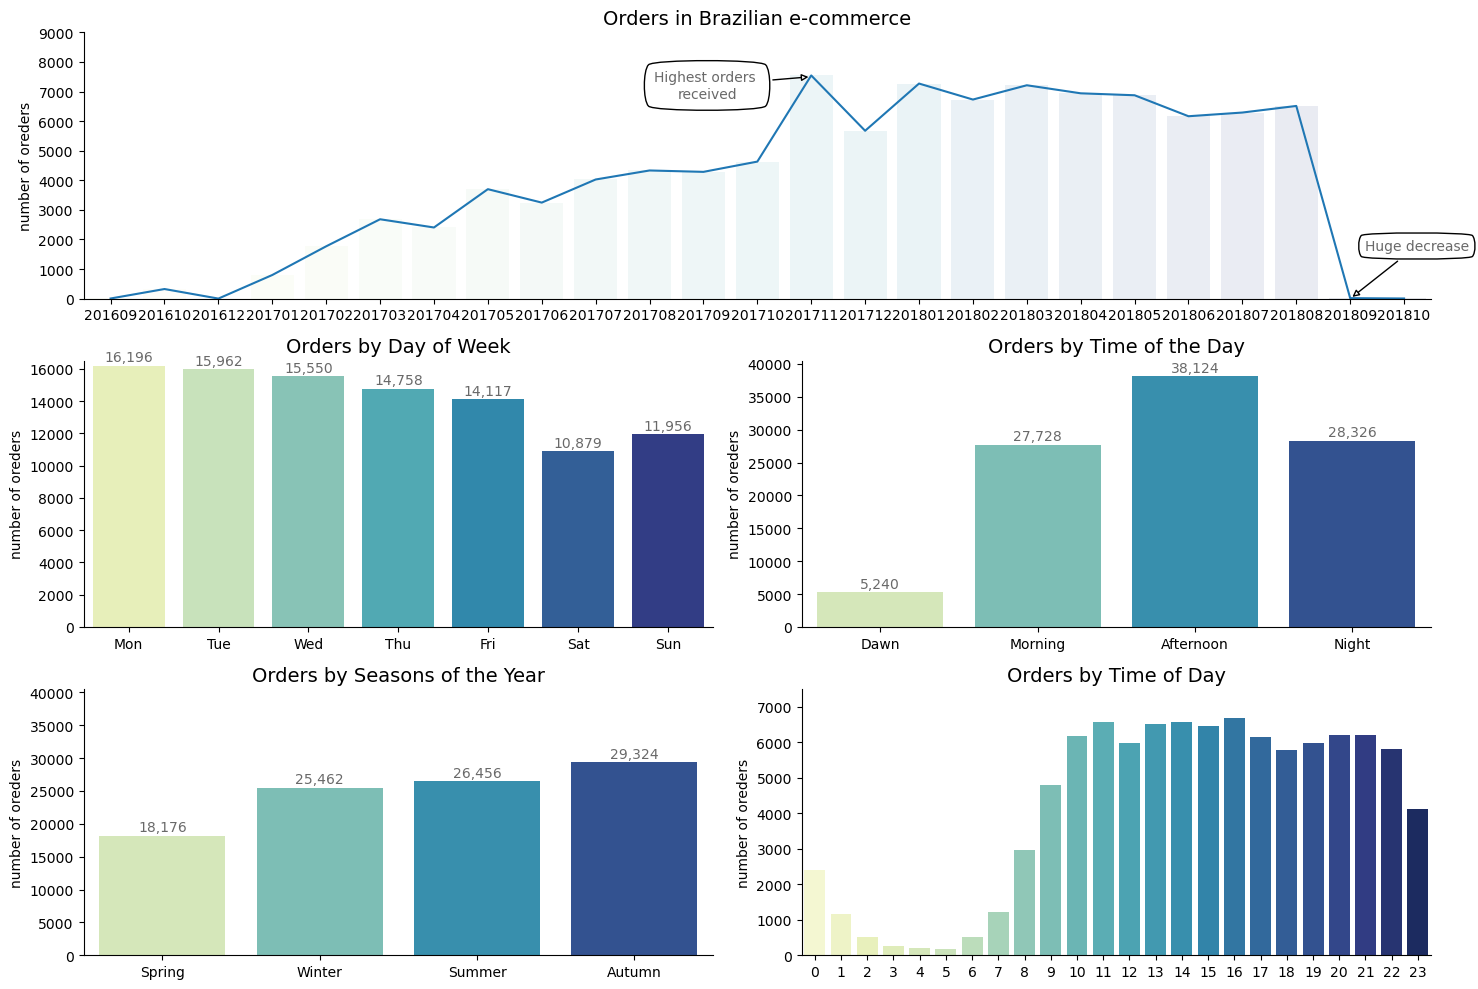

In [80]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Lineplot/Barplot - Evolution of e-commerce orders along time 
sns.lineplot(x="order_purchase_year_month", y="order_id", data=orders.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(), ax=ax1, legend=False)
sns.barplot(x="order_purchase_year_month", y="order_id", data=orders.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(), ax=ax1, alpha=0.1, palette='YlGnBu')

ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -15), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Huge decrease', (23, 0), xytext=(48, 35), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax1.set_title("Orders in Brazilian e-commerce", size=14, color='black')
ax1.set_ylabel("number of oreders")
ax1.set_xlabel("")
ax1.set_ylim(0,9000)

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Barchart - Total of orders by day of week
day_order= ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.countplot(x="order_purchase_dayofweek_name", data=orders, order=day_order, ax=ax2, palette="YlGnBu")
ax2.set_title("Orders by Day of Week", size=14, color='black')
ax2.set_xlabel("")
ax2.set_ylabel("number of oreders")
ax2.set_ylim(0,16500)

for p in ax2.patches:
        ax2.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= "dimgrey")
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Barchart - Total of orders by time of the day
sns.countplot(x="order_purchase_time_day", data=orders,ax=ax3, palette="YlGnBu")
ax3.set_title("Orders by Time of the Day", size=14, color='black')
ax3.set_xlabel("")
ax3.set_ylabel("number of oreders")
ax3.set_ylim(0,40500)

for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                     ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= "dimgrey")
        
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Barchart - Total of orders by season of year
sns.countplot(x="order_purchase_season", data=orders,ax=ax4, palette="YlGnBu")
ax4.set_title("Orders by Seasons of the Year", size=14, color='black')
ax4.set_xlabel("")
ax4.set_ylabel("number of oreders")
ax4.set_ylim(0,40500)

for p in ax4.patches:
        ax4.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                     ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= "dimgrey")
        
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Barchart - Total of orders by hour of the day
sns.countplot(x="order_purchase_hour", data=orders,ax=ax5, palette="YlGnBu")
ax5.set_title("Orders by Time of Day", size=14, color='black')
ax5.set_xlabel("")
ax5.set_ylabel("number of oreders")
ax5.set_ylim(0,7500)
        
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Knowing which days of the week and time periods of the day spend more time shopping is a good way to offer the right promotions at the right time.

We see that the shopping density is higher during the week.
In terms of hours, we see that the orders continue in a balanced way throughout the day, even after they reach the peak before 12.

It is not meaningful to comment on seasonality as there is an increasing trend in the dataset we have in 2017 and there is no all year data for 2018.

In [82]:
fig1 = plt.figure(constrained_layout=True, figsize=(20, 17))

# Axis definition
gs1 = GridSpec(4, 2, figure=fig)
ax6 = fig1.add_subplot(gs1[0, 0])
ax7 = fig1.add_subplot(gs1[0, 1])
ax8 = fig1.add_subplot(gs1[1, 0])
ax9 = fig1.add_subplot(gs1[1, 1])
ax10 = fig1.add_subplot(gs1[2, 0])
ax11 = fig1.add_subplot(gs1[2, 1])
ax12 = fig1.add_subplot(gs1[3, 0])
ax13 = fig1.add_subplot(gs1[3, 1])

# February of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201802'] ,ax=ax6, palette="YlGnBu")

ax6.set_title("February of 2018", size=14, color='black')
ax6.set_xlabel("")
ax6.set_ylabel("")
        
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# March of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201803'] ,ax=ax7, palette="YlGnBu")

ax7.annotate(f'Consumers Day', (14, 280), xytext=(-60, -2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax7.set_title("March of 2018", size=14, color='black')
ax7.set_xlabel("")
ax7.set_ylabel("")
        
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)

# April of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201804'] ,ax=ax8, palette="YlGnBu")

ax8.annotate(f'Free Shipping Day', (26, 240), xytext=(-70, -2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax8.set_title("April of 2018", size=14, color='black')
ax8.set_xlabel("")
ax8.set_ylabel("")
        
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)

# May of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201805'] ,ax=ax9, palette="YlGnBu")

ax9.annotate(f'Mothers’ Day', (12, 200), xytext=(-60, -2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax9.set_title("May of 2018", size=14, color='black')
ax9.set_xlabel("")
ax9.set_ylabel("")
        
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)

# June of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201806'] ,ax=ax10, palette="YlGnBu")

ax10.annotate(f'Valentine’s Day', (11, 250), xytext=(60, 2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax10.set_title("June of 2018", size=14, color='black')
ax10.set_xlabel("")
ax10.set_ylabel("")
        
ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

# August of 2018
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201808'] ,ax=ax11, palette="YlGnBu")

ax11.annotate(f'Fathers’ Day', (11, 180), xytext=(-60, -2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax11.set_title("August of 2018", size=14, color='black')
ax11.set_xlabel("")
ax11.set_ylabel("")
        
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)

# November of 2017
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201711'] ,ax=ax12, palette="YlGnBu")

ax12.annotate(f'Black Friday', (23, 1160), xytext=(-60, -2), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax12.annotate(f'Singles Day', (10, 170), xytext=(0, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax12.set_title("November of 2017", size=14, color='black')
ax12.set_xlabel("")
ax12.set_ylabel("")
        
ax12.spines['top'].set_visible(False)
ax12.spines['right'].set_visible(False)

# December of 2017
sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201712'] ,ax=ax13, palette="YlGnBu")

ax13.annotate(f'Christmas', (24, 100), xytext=(0, 40), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

ax13.set_title("December of 2017", size=14, color='black')
ax13.set_xlabel("")
ax13.set_ylabel("")
        
ax13.spines['top'].set_visible(False)
ax13.spines['right'].set_visible(False)

C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\3557482402.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201802'] ,ax=ax6, palette="YlGnBu")
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\3557482402.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="order_purchase_day", data = orders[orders['order_purchase_year_month'] == '201803'] ,ax=ax7, palette="YlGnBu")
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\3557482402.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Error in callback <function _draw_all_if_interactive at 0x00000224070063E0> (for post_execute), with arguments args (),kwargs {}:


KeyError: <Figure size 1500x1000 with 5 Axes>

KeyError: <Figure size 1500x1000 with 5 Axes>

<Figure size 2000x1700 with 8 Axes>

Special campaigns and category-based discounts should be made for important shopping periods. These periods are very suitable for strategic marketing for e-commerce.

###Product

In [85]:
# products and order_items table are combined on product_id
products_order = products.merge(order_items, how='left', on='product_id') 
# Calculates the total value that the customer paid for the product
products_order["total"] = products_order["price"] + products_order["freight_value"]
# products_order and orders table are combined on order_id to get date information
products_order = products_order.merge(orders, how='left', on="order_id")
# dataframe with the columns we just need
products_order = products_order[["product_id", "price" , "freight_value", "total", "product_category_name_english","order_purchase_year","order_purchase_month_name","order_purchase_year_month"]]
products_order.head(2)

,product_id,price,freight_value,total,product_category_name_english,order_purchase_year,order_purchase_month_name,order_purchase_year_month
0,1e9e8ef04dbcff4541ed26657ea517e5,10.91,7.39,18.30,perfumery,2018.0,Apr,201804
1,3aa071139cb16b67ca9e5dea641aaa2f,248.00,17.99,265.99,art,2018.0,Jan,201801


In [179]:
# Grouped by category to create a scatterplot, top takes 15 categories
products_order_category = products_order.groupby("product_category_name_english").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(15)
products_order_category.head(1)

,product_category_name_english,order_purchase_year_month,total
7,bed_bath_table,11114,1241681.72


In [87]:
products_order_category_trends = products_order.groupby(by=["product_category_name_english","order_purchase_year_month"]).agg({"order_purchase_year" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year_month","order_purchase_year","product_category_name_english"], ascending=[True,False,False])
# Filters the categories that are in the Top 5
products_order_category_trends = products_order_category_trends[(products_order_category_trends["product_category_name_english"]=="bed_bath_table") | 
                                                                (products_order_category_trends["product_category_name_english"]=="furniture_decor")|
                                                                (products_order_category_trends["product_category_name_english"]=="sports_leisure")|
                                                                (products_order_category_trends["product_category_name_english"]=="health_beauty")|
                                                                (products_order_category_trends["product_category_name_english"]=="computers_accessories")]
products_order_category_trends.head(2) 

,product_category_name_english,order_purchase_year_month,order_purchase_year,total
746,health_beauty,201609,3,143.46
672,furniture_decor,201609,2,136.23


C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2808541669.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(data['total'],data['order_purchase_year_month'],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2808541669.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(data['total'],data['order_purchase_year_month'],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2808541669.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(data['total'],data['order_purchase_year_month'],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2808541669.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(data['total'],data['order_purchase_year_month'],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2808541669.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters '

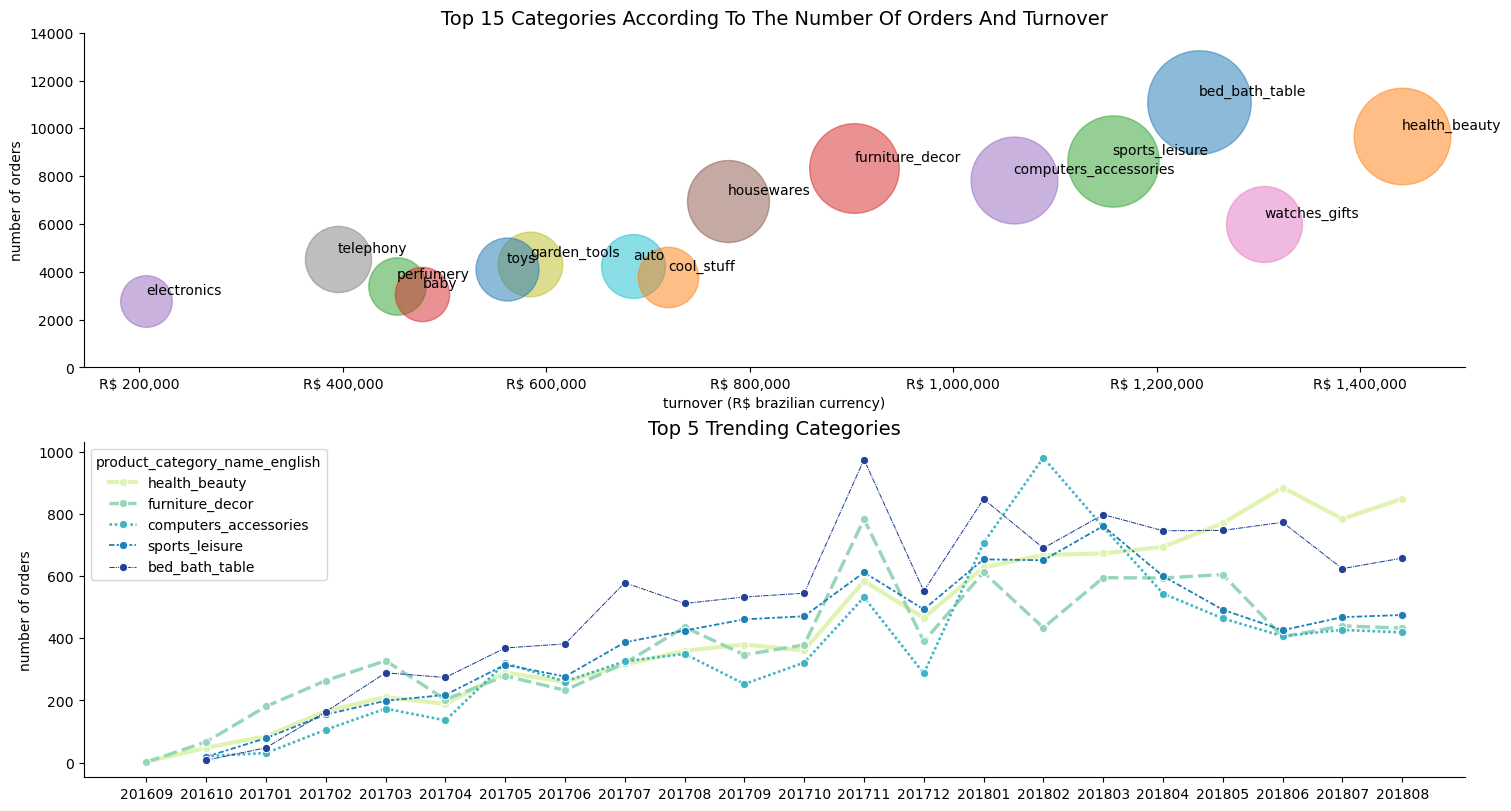

In [88]:
fig = plt.figure(constrained_layout=True, figsize=(15, 8))

# Axis definition
gs = GridSpec(6, 2, figure=fig)
ax1 = fig.add_subplot(gs[:3,0:])
ax2 = fig.add_subplot(gs[3:,0:])

# Scatterplot for the top 15 categories
for product in products_order_category["product_category_name_english"].unique():
    data = products_order_category[products_order_category["product_category_name_english"] == product]
    ax1.scatter(data['total'],data['order_purchase_year_month'],
                s=0.5*data['order_purchase_year_month']**1,
                alpha = 0.5,
                label=product, cmap='YlGnBu')
    
for index, row in products_order_category.iterrows():
    ax1.annotate(row['product_category_name_english'],
                 (row['total'], row['order_purchase_year_month']),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='left')
    
ax1.set_xlabel("turnover (R$ brazilian currency)")
ax1.set_ylabel("number of orders")
ax1.set_title("Top 15 Categories According To The Number Of Orders And Turnover", size=14)
ax1.set_ylim(0,14000)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('R$ {x:,.0f}'))

# Lineplot for top 5 most ordered categories
sns.lineplot(x='order_purchase_year_month', y='order_purchase_year', data=products_order_category_trends, ax=ax2, hue='product_category_name_english',legend=True, style='product_category_name_english', size='product_category_name_english', marker='o', linewidth=3, palette="YlGnBu")
ax2.set_title("Top 5 Trending Categories", size=14)
ax2.set_ylabel("number of orders")
ax2.set_xlabel("")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

In the scatter plot, we examine the categories both according to the turnover they bring and the number of orders. The width of the circles is proportional to the number of orders. Although the watch category has a good revenue in terms of turnover, it is not among the top 5 orders.

If we look at the 5 most ordered categories over time, we see that the demand in the bed bath table and health beauty categories has increased.

We are examining the first 5 categories of special days, which attract attention with their order rates.

In [91]:
# mothers day
productsxx = products_order[products_order['order_purchase_year_month'] == '201805'].groupby("product_category_name_english").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(5)
productsxx.head()

,product_category_name_english,order_purchase_year_month,total
38,health_beauty,770,110477.15
7,bed_bath_table,747,85173.53
62,watches_gifts,636,132617.95
43,housewares,619,76453.58
35,furniture_decor,605,65724.64


Unlike the top 5 categories, watches_gifts and housewares categories draw attention on mothers day.

In [93]:
# fathers day
productsxy = products_order[products_order['order_purchase_year_month'] == '201808'].groupby("product_category_name_english").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(5)
productsxy.head()

,product_category_name_english,order_purchase_year_month,total
39,health_beauty,849,137206.07
7,bed_bath_table,658,75207.83
44,housewares,629,74238.89
58,sports_leisure,475,60374.75
36,furniture_decor,433,51976.65


Unlike the top 5 categories, the housewares category draws attention on father's day.

In [95]:
# black friday
productsyy = products_order[products_order['order_purchase_year_month'] == '201711'].groupby("product_category_name_english").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(5)
productsyy.head()

,product_category_name_english,order_purchase_year_month,total
6,bed_bath_table,975,106669.19
36,furniture_decor,783,78082.92
59,sports_leisure,612,75610.20
40,health_beauty,584,89633.09
39,garden_tools,550,58200.10


Unlike the top 5 categories, the garden_tools category draws attention in black friday. Black Friday is spring in Brazil. With the arrival of summer, it can be said that shopping is done in this category by taking advantage of the discount.

### Reviews

In [98]:
# Some properties that may be required in the order_reviews table
scorelist = [(order_reviews["review_score"] <=2),(order_reviews["review_score"] == 3),(order_reviews["review_score"] >= 4)]
classscorelist = ["Negative", "Neutral", "Positive"]
order_reviews["score_class"] = np.select(scorelist, classscorelist, default='Not Specified')

# Classification for review_comment_message
commentlist = [(order_reviews["review_comment_message"].isnull())]
classcommentlist = ["No Comment"]
order_reviews["comment_class"] = np.select(commentlist, classcommentlist, default="With Comment")

order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,score_class,comment_class
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,Positive,No Comment
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,Positive,No Comment
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,Positive,No Comment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,Positive,With Comment
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,Positive,With Comment


In [99]:
orders1 = orders.merge(order_reviews, how='left', on='order_id') # orders and order_reviews table are combined on order_id
orders1.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delayed,delay_time,...,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_purchase_season,review_id,review_score,review_comment_title,review_comment_message,score_class,comment_class
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,-8 days +21:25:13,...,Mon,10,Morning,Spring,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",Positive,With Comment
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,-6 days +15:27:45,...,Tue,20,Night,Winter,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,Positive,With Comment


C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\1520756837.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="review_score", y="review_id", data=order_reviews.groupby("review_score").count()["review_id"].reset_index(), ax=ax1, palette="GnBu")


Text(0.5, 1.0, 'Delivery Status')

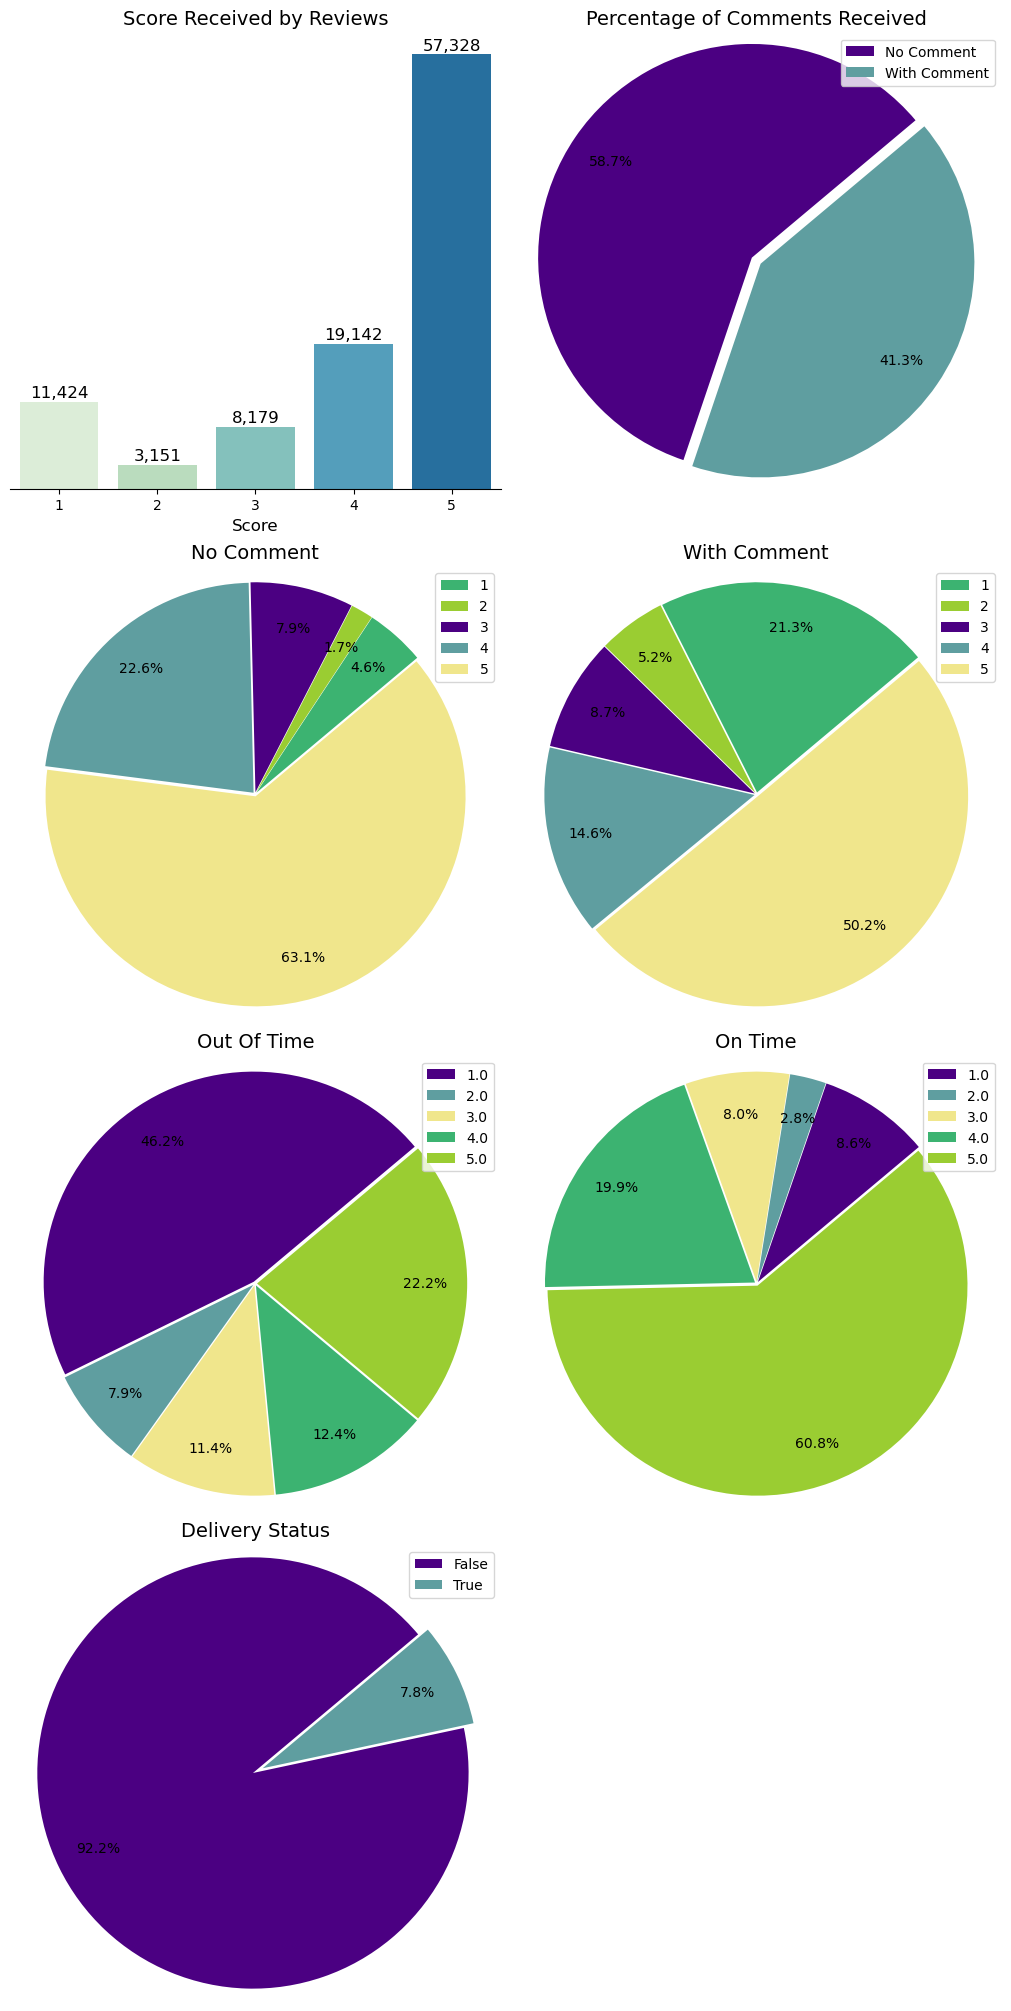

In [100]:
fig = plt.figure(constrained_layout=True, figsize=(10, 20))

# Axis definition
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])

# Score distribution of orders on bar plot
sns.barplot(x="review_score", y="review_id", data=order_reviews.groupby("review_score").count()["review_id"].reset_index(), ax=ax1, palette="GnBu")
ax1.set_xlabel("Score", size=12)
ax1.set_ylabel("")
ax1.set_title("Score Received by Reviews", size=14, color="black")
for p in ax1.patches:
        ax1.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticklabels([])
ax1.set_yticks([])

# Percentage of Comments Received on pie chart
comment_classification = order_reviews.groupby("comment_class").count()["review_id"].reset_index()
colors = ['indigo', 'cadetblue', 'khaki', 'mediumseagreen', 'yellowgreen']
ax2.pie(comment_classification["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.0, 0.05), colors=colors)
ax2.axis('equal') 
ax2.legend(labels=comment_classification["comment_class"], loc='upper right')
ax2.set_title("Percentage of Comments Received", size=14, color='black')

# Score distribution of orders without comments on pie chart
colors1 = ['mediumseagreen', 'yellowgreen', 'indigo', 'cadetblue', 'khaki', ]
reviews1 = order_reviews[order_reviews.comment_class == 'No Comment']
classification11 = reviews1.groupby("review_score").count()["review_id"].reset_index()
ax3.pie(classification11["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.01, 0.01, 0.01, 0.01, 0.01), colors=colors1)
ax3.axis('equal') 
ax3.legend(labels=classification11["review_score"], loc='upper right')
ax3.set_title("No Comment", size=14, color='black')

# Score distribution of orders with comments on pie chart
reviews2 = order_reviews[order_reviews.comment_class == 'With Comment']
classification22 = reviews2.groupby("review_score").count()["review_id"].reset_index()
ax4.pie(classification22["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.01, 0.01, 0.01, 0.01, 0.01), colors=colors1)
ax4.axis('equal') 
ax4.legend(labels=classification22["review_score"], loc='upper right')
ax4.set_title("With Comment", size=14, color='black')

# Score distribution of orders delivered out of time on pie chart
orders2 = orders1[orders1.delayed ==True]
classification1 = orders2.groupby("review_score").count()["review_id"].reset_index()
ax5.pie(classification1["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.01, 0.01, 0.01, 0.01, 0.01), colors=colors)
ax5.axis('equal') 
ax5.legend(labels=classification1["review_score"], loc='upper right')
ax5.set_title("Out Of Time", size=14, color='black')

# Score distribution of orders delivered on time on pie chart
orders3 = orders1[orders1.delayed ==False]
classification2 = orders3.groupby("review_score").count()["review_id"].reset_index()
ax6.pie(classification2["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.01, 0.01, 0.01, 0.01, 0.01), colors=colors)
ax6.axis('equal') 
ax6.legend(labels=classification1["review_score"], loc='upper right')
ax6.set_title("On Time", size=14, color='black')

# Delivery status of orders on pie chart
delayed_classification = orders1.groupby("delayed").count()["review_id"].reset_index()
ax7.pie(delayed_classification["review_id"], autopct='%1.1f%%',shadow=False, startangle=40, pctdistance=0.8, explode=(0.0, 0.05), colors=colors)
ax7.axis('equal') 
ax7.legend(labels=delayed_classification["delayed"], loc='upper right')
ax7.set_title("Delivery Status", size=14, color='black')

Orders received high ratings overall. About 59 percent of orders have no comments. We see that the satisfaction is high when there are no comments, but low points are given when there are comments. This is useful for detecting and improving dissatisfaction.

When we look at the scores according to the delivery status of the orders, it is seen that the low scores increase in the delayed orders. This shows that order delivery times are an important factor in satisfaction.

### Payment

C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\261245423.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="payment_installments", data=order_payments, ax=ax2, palette="viridis")


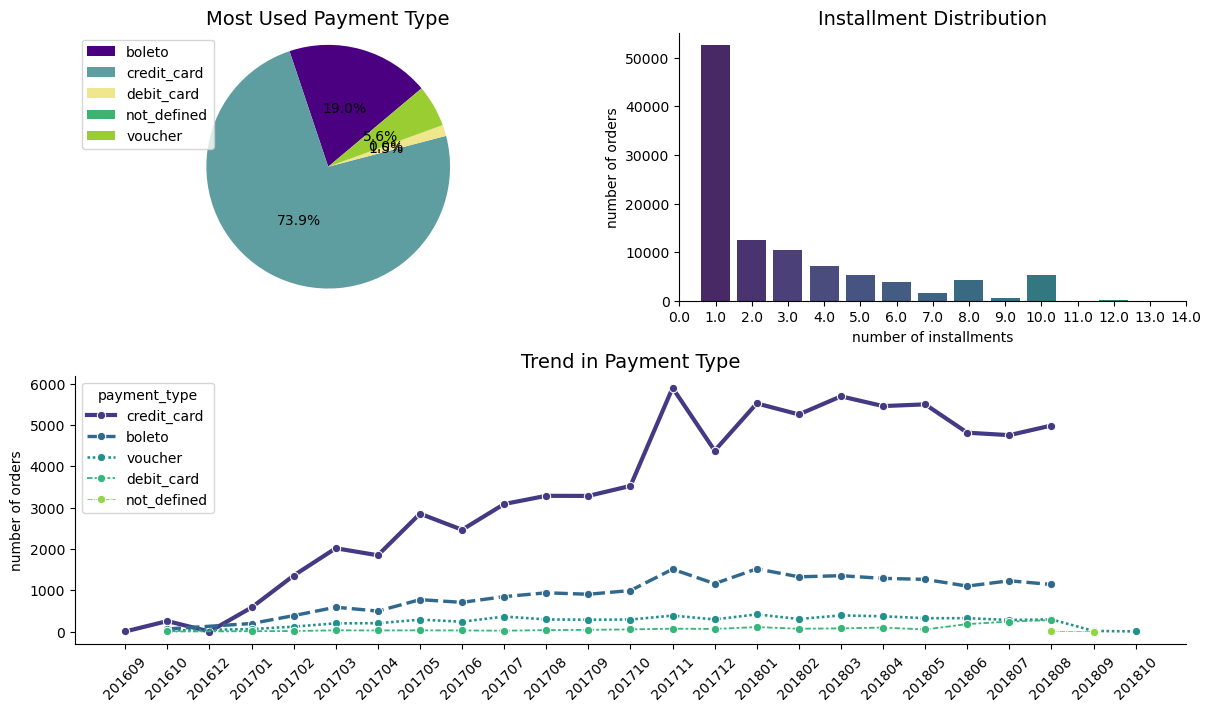

In [103]:
# orders and order_payments table are combined on product_category_name
order_payments = orders.merge(order_payments, how='left', on='order_id')

fig = plt.figure(constrained_layout=True, figsize=(12, 7))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Pie chart display of payment methods
colors = ['indigo', 'cadetblue', 'khaki', 'mediumseagreen', 'yellowgreen']
payment_classification = order_payments.groupby("payment_type").count()["order_id"].reset_index()
ax1.pie(payment_classification["order_id"], autopct='%1.1f%%', startangle=40, pctdistance=0.5, colors=colors)
ax1.axis('equal') 
ax1.legend(labels=payment_classification["payment_type"], loc='upper left')
ax1.set_title("Most Used Payment Type", size=14, color='black')

# Installment Distribution in orders
sns.countplot(x="payment_installments", data=order_payments, ax=ax2, palette="viridis")
ax2.set_title('Installment Distribution', color='black', size=14)
ax2.set_xlabel("number of installments")
ax2.set_ylabel("number of orders")
ax2.set_xlim(0,14)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Trend of payment methods over time
payment = order_payments.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment = payment.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment = payment.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment, ax=ax3, hue='payment_type', legend=True,
             style='payment_type', size='payment_type', palette="viridis", linewidth=3, marker='o')

ax3.set_ylabel("number of orders")
ax3.set_xlabel("")
ax3.spines['top'].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title('Trend in Payment Type', size=14, color='black')
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

plt.show()

We can say that payments made by credit card have an important place in Brazilian e-commerce. While there was a decrease in the use of credit cards in May 2018, it is seen that the use of debit cards increased. It will be a good opportunity for investors to improve their services for such payments.

Considering the use of installments in orders, mostly single withdrawals are made, but payments made in 10 installments also draw attention.

### Correlation

Correlation between freight value and price

In [107]:
round(order_items['freight_value'].corr(order_items['price']), 2)

0.41

<Axes: xlabel='price', ylabel='freight_value'>

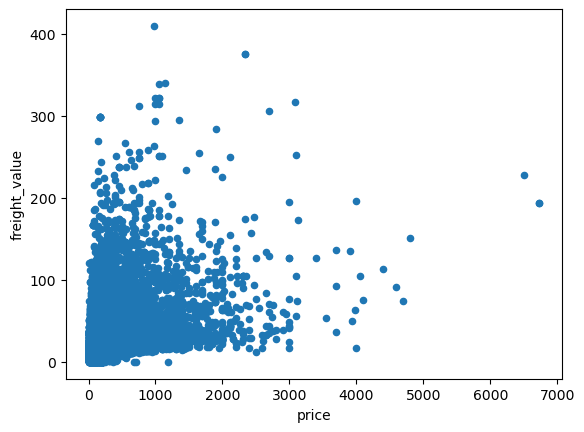

In [108]:
order_items.plot(kind = 'scatter', x = 'price', y = 'freight_value',)

Correlation between freight value and product volume

In [110]:
products2 = products.merge(order_items, how='left', on='product_id') 
products2.head()

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,1000.0,30.0,18.0,20.0,art,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,154.0,18.0,9.0,15.0,sports_leisure,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82
3,cef67bcfe19066a932b7673e239eb23d,371.0,26.0,4.0,26.0,baby,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54
4,9dc1a7de274444849c219cff195d0b71,625.0,20.0,17.0,13.0,housewares,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29


In [111]:
products2['volume'] = products2['product_length_cm'] * products2['product_height_cm'] * products2['product_width_cm']
products2.head()

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,volume
0,1e9e8ef04dbcff4541ed26657ea517e5,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,1000.0,30.0,18.0,20.0,art,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,10800.0
2,96bd76ec8810374ed1b65e291975717f,154.0,18.0,9.0,15.0,sports_leisure,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,2430.0
3,cef67bcfe19066a932b7673e239eb23d,371.0,26.0,4.0,26.0,baby,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,2704.0
4,9dc1a7de274444849c219cff195d0b71,625.0,20.0,17.0,13.0,housewares,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,4420.0


In [112]:
round(products2['freight_value'].corr(products2['volume']), 2)

0.59

<Axes: xlabel='volume', ylabel='freight_value'>

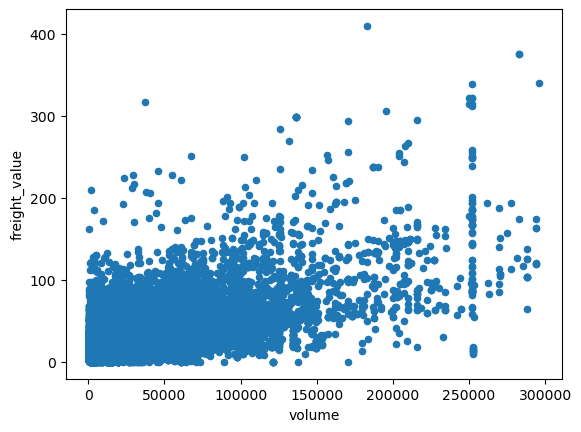

In [113]:
products2.plot(kind = 'scatter', x = 'volume', y = 'freight_value',)

Correlation between frequency value and product weight

In [115]:
round(products2['freight_value'].corr(products2['product_weight_g']), 2)

0.61

<Axes: xlabel='product_weight_g', ylabel='freight_value'>

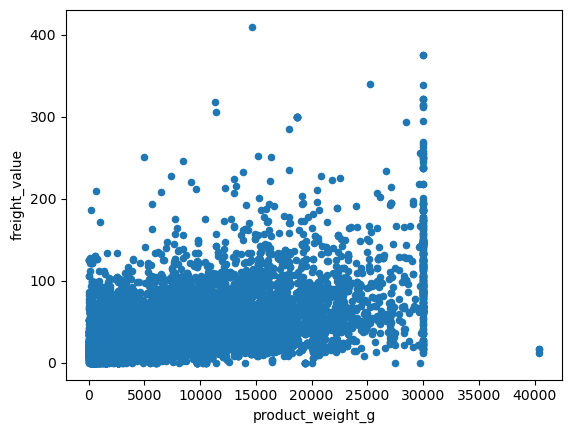

In [116]:
products2.plot(kind = 'scatter', x = 'product_weight_g', y = 'freight_value',)

It is seen that there is a relationship between the Freight value and the weight of the product the most, and then the volume that can cause the weight, and this relationships are significant.

### Geospatil

In [119]:
# First orders and order_items are merged then separately with customers and sellers tables
df_orders_items = orders.merge(order_items, how='left', on='order_id')
df_orders_items = customer.merge(df_orders_items, how='left', on='customer_id')

df_orders_seller = sellers.merge(df_orders_items, how='left', on='seller_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = geolocation[geolocation.geolocation_lat <= 5.27438888]
# It’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
# It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
# It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations - customer
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,21.88,35,SP,São Paulo,Sudeste,14409.0,-20.519565,-47.409694,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,46.48,35,SP,São Paulo,Sudeste,9790.0,-23.735663,-46.597952,sao bernardo do campo,SP


In [120]:
# Merging all the informations - seller
df_orders_seller = df_orders_seller.merge(br_info, how='left', left_on='seller_state', right_on='sigla')
df_orders_seller = df_orders_seller.merge(geo_group, how='left', left_on='seller_zip_code_prefix', 
                                          right_on='geolocation_zip_code_prefix')
df_orders_seller.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,...,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,a973c4e3ad82777add3fa188f91dacea,b4527423469300ee354458e1b5f961be,32223,contagem,MG,6d953888a914b67350d5bc4d48f2acab,...,15.92,35,SP,São Paulo,Sudeste,13023.0,-22.900175,-47.066168,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,1554ffe702931a062b4383b109accf63,af0f26435fade1ca984d9affda307199,9310,maua,SP,bc8a5de6abf5b14f98a6135a7fb46731,...,2.42,35,SP,São Paulo,Sudeste,13023.0,-22.900175,-47.066168,campinas,SP


In [121]:
# Grouping data by region
df_regions_group = df_orders_items.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_items.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

# Grouping data by state (top 10)
df_state_group = df_orders_items.groupby(by='geolocation_state', 
                                       as_index=False).count().loc[:, ['geolocation_state', 'order_id']]
df_state_group = df_state_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_state_group = df_state_group.iloc[:10, :]

C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2405318775.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='YlGnBu')
C:\Users\Hp\AppData\Local\Temp\ipykernel_9176\2405318775.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='geolocation_state', x='order_id', ax=ax3, data=df_state_group, palette='viridis')


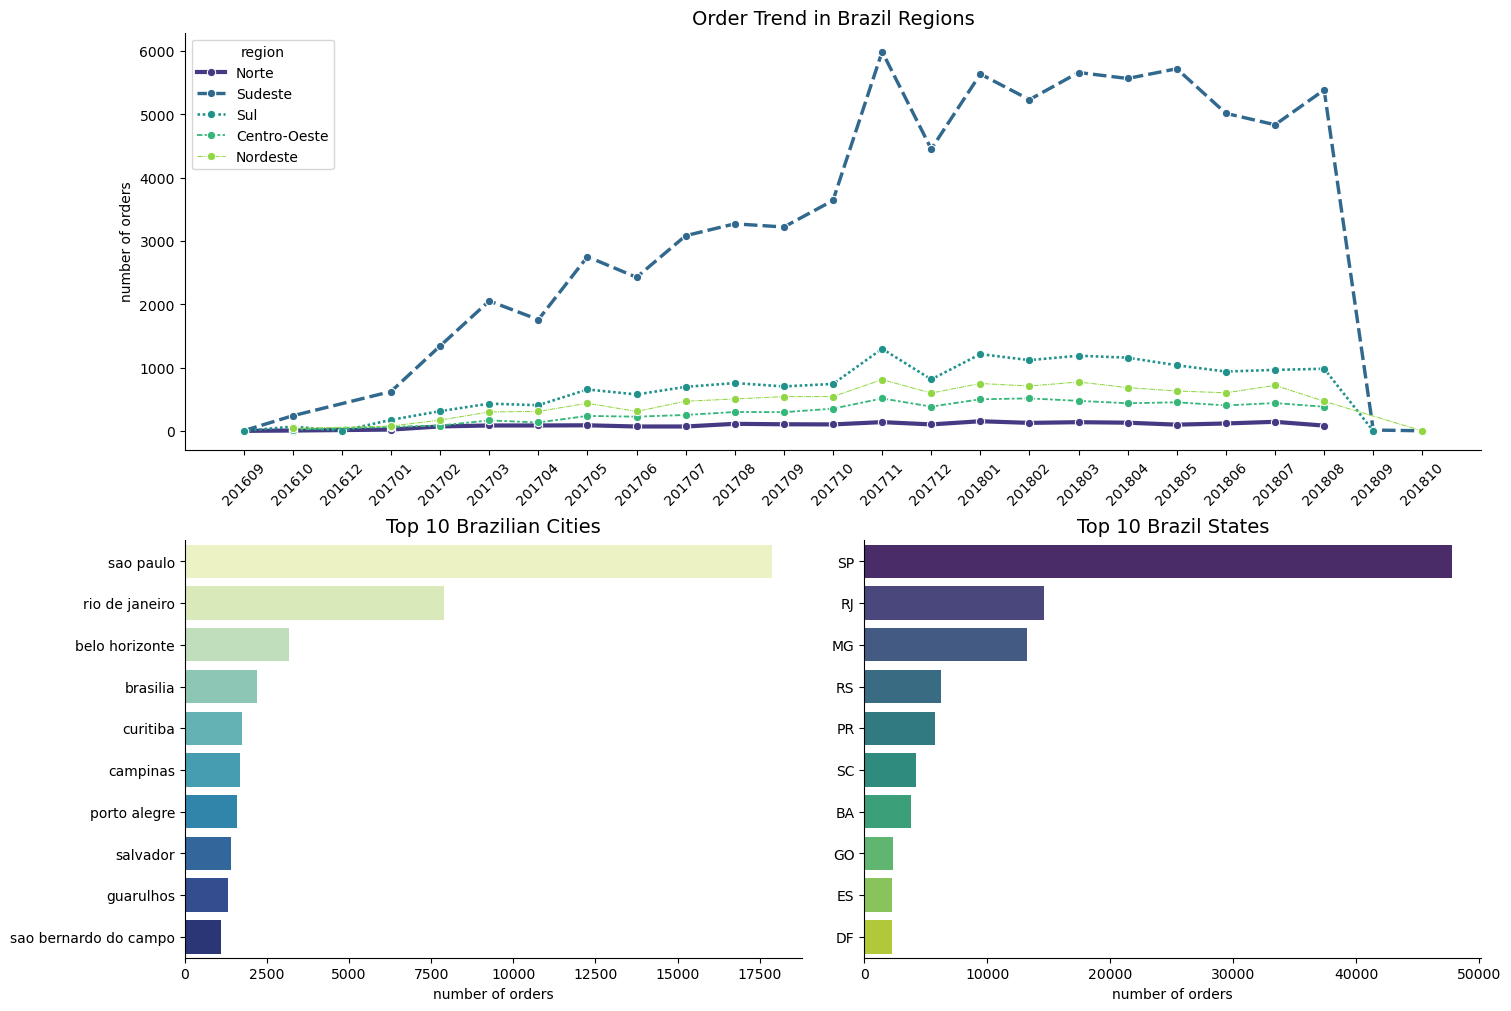

In [122]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='viridis', markers=['o'] * 5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Order Trend in Brazil Regions', size=14, color='black')
ax1.set_ylabel("number of orders")
ax1.set_xlabel("")
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='YlGnBu')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Top 10 Brazilian Cities', size=14, color='black')
ax2.set_ylabel("")
ax2.set_xlabel("number of orders")

# Total orders by state
sns.barplot(y='geolocation_state', x='order_id', ax=ax3, data=df_state_group, palette='viridis')
ax3.set_title('Top 10 Brazil States', size=14, color='black')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_ylabel("")
ax3.set_xlabel("number of orders")

plt.show()

The most orders are in the southeast(sudeste) of Brazil.

In [124]:
# Grouping geolocation data for plotting a heatmap
heat_data_customer = df_orders_items.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]
# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles='cartodbdark_matter')
# Plugin: HeatMap
HeatMap(name='Heat Map - Customers', data=heat_data_customer, radius=10, max_zoom=13).add_to(map1)

map1

In [125]:
# Grouping geolocation data for plotting a heatmap
heat_data_seller = df_orders_seller.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]
# Creating a mapa using folium
map2 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles='cartodbdark_matter')
# Plugin: HeatMap
HeatMap(name='Heat Map - Sellers', data=heat_data_seller, radius=10, max_zoom=13).add_to(map2)

map2

Looking at the heatmap of customer and vendor densities, it is seen that vendors are located in a smaller region than customers. This will concern many issues from delivery time to customer satisfaction.